# Project Definition

## Audience
The marketing department has requested this analysis. Data includes campaign spendings, web interactions, user demographics, product reviews so we focus on marketing insights.
<br>

## Objective
What patterns in our customers’ journeys drive spend, repeat purchases, and campaign ROI, and how can Marketing optimize touchpoints to boost revenue and retention?
<br>

## Scope
**Datasets**: Campaign logs, Customer demographics, Customer reviews, Session interactions, Purchases<br>
**Time Frame**: 5 years, March 2020 - February 2025<br>
**Exclusion**: Support tickets

# Importing

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import plotly.graph_objects as go

from collections import Counter
from functools import reduce
from datetime import datetime

In [129]:
fig_width = 7
fig_height = 4

primary = "#F5C45E" # yellow
secondary = "#E78B48" # orange
background = "#102E50" # dark blue

color1 = "#03B5AA" # green
color2 = "#F0386B" # red
color3 = "#EDC9FF" # purple
color4 = "#00CFC1" # green 2
color5 = "#F7F7FF" # white
color6 = "#F88DAD" # pink
color7 = "#40F99B" # electric green
color8 = "#C20114" # very red
color9 = "#51CB20" # very green
color10 = "#07A0C3" # blue

plot_style = [{"c": primary, "alpha": 0.8,},
              {"c": color9, "alpha": 0.8,}, 
              {"c": secondary, "alpha": 0.8,}, 
              {"c": color3, "alpha": 0.8,}]

bar_style = [{"color": secondary,"alpha": 0.8, "edgecolor": color5},
             {"color": color7,"alpha": 0.8,"edgecolor": color5}, 
             {"color": color6,"alpha": 0.8,"edgecolor": color5}, 
             {"color": color5,"alpha": 0.8,"edgecolor": color5}]

xline_style = [{"color": color2, "linestyle": "-."},
               {"color": color6, "linestyle": "-."}, 
               {"color": color10, "linestyle": "-."}, 
               {"color": color8, "linestyle": "-."}]

bbox_style = {
    "boxstyle": "square", 
    "pad":0.3, 
    "fc": "none", 
    "ec": "none", 
    "lw": 0
}

annot_style = {
    "arrowprops": {
        "arrowstyle": "-",
        "color": color1
    }, 
    "bbox": bbox_style, 
    "zorder": 0, 
    "color": secondary,
    "fontsize": 8, 
    "va": "center"
}

pie_style = {
    "wedgeprops": {
        "width":0.5
    }, 
    "startangle": -40,
}

scatter_style = [{"alpha": 0.8, "c": primary, "edgecolors": secondary, "s": 60}]

rcParams['figure.facecolor'] = background
rcParams['axes.facecolor'] = background

rcParams['figure.figsize'] = (fig_width, fig_height)
rcParams['figure.dpi'] = 120  

rcParams['axes.edgecolor'] = secondary
rcParams['axes.linewidth'] = 1.5

rcParams['grid.linestyle'] = '--'
rcParams['grid.alpha'] = 0.3
rcParams['grid.color'] = secondary

# rcParams["font.family"] = "Roboto"
rcParams["font.size"] = 12
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 14
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelcolor'] = secondary
rcParams['axes.titlecolor'] = secondary

rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['xtick.color'] = secondary
rcParams['ytick.color'] = secondary

rcParams['figure.autolayout'] = True

In [130]:
from os import walk

path = "../data/processed/"
filenames = next(walk(path), (None, None, []))[2]
print(filenames)

['campaigns.csv', 'customers.csv', 'customer_reviews_complete.csv', 'interactions.csv', 'support_tickets.csv', 'transactions.csv']


In [131]:
campaigns = pd.read_csv(path+"campaigns.csv")
customers = pd.read_csv(path+"customers.csv")
customer_reviews_complete = pd.read_csv(path+"customer_reviews_complete.csv")
interactions = pd.read_csv(path+"interactions.csv")
support_tickets = pd.read_csv(path+"support_tickets.csv")
transactions = pd.read_csv(path+"transactions.csv")

# Guiding Questions

## 1. Sales Efficiency
How much revenue do we get per session and per unique user?

Efficiency = Total Revenue / Total Sessions / Total Customers

In [132]:
sessions_per_user = interactions.groupby(["customer_id"])["session_id"].nunique().reset_index()

transactions_online = transactions[transactions["store_location"] == "Online"].copy()
transactions_online["amount"] = transactions_online["quantity"] * transactions_online["price"]
transactions_per_user = transactions_online.groupby(["customer_id"])["amount"].sum().reset_index()

transactions_per_session_per_user = sessions_per_user.merge(transactions_per_user, 
                                                            left_on="customer_id",
                                                            right_on="customer_id").rename(columns={"session_id": "sessions"})

sessions_per_user = None
transactions_online = None
transactions_per_user = None

In [133]:
revenue_per_session_per_user = ((transactions_per_session_per_user["amount"].sum() / 
                                 transactions_per_session_per_user["sessions"].sum()) / 
                                 transactions_per_session_per_user["customer_id"].count())

revenue_per_session_per_user

np.float64(0.07555619456865115)

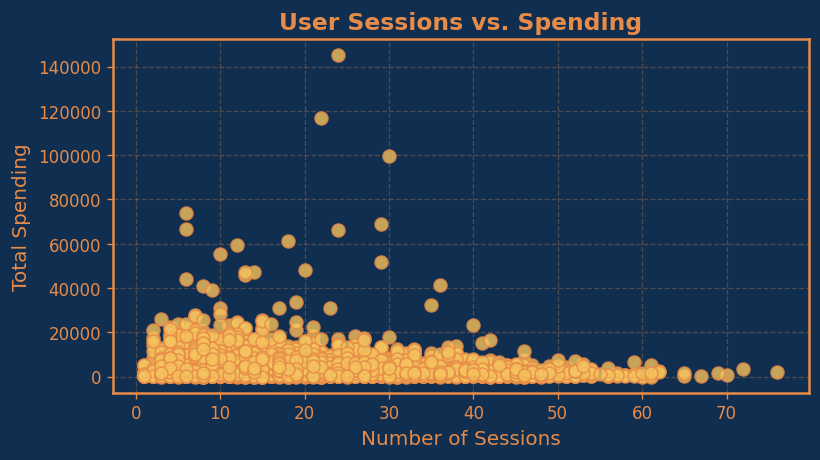

In [134]:
fig, ax = plt.subplots()

ax.scatter(transactions_per_session_per_user["sessions"], 
            transactions_per_session_per_user["amount"], 
            **scatter_style[0])

ax.set_xlabel("Number of Sessions")
ax.set_ylabel("Total Spending")
ax.set_title("User Sessions vs. Spending")
ax.grid(True)
plt.tight_layout()
plt.show()

## 2. Customer Value & Segmentation
What is each user’s lifetime value (LTV), and how do “new,” “loyal,” “one‑time,” and “churned” segments differ?

CLTV = Average Order Value × Purchase Frequency × Average Customer Lifespan<br>
Average Order Value (AOV) = Total Revenue / Total Orders<br>
Purchase Frequency (PF) = Total Orders / Unique Customers<br>
Average Customer Lifespan (ACL) = Avg time (in months or years) customers stay active

In [135]:
transactions_online = transactions[transactions["store_location"] == "Online"].copy()

transactions_online["amount"] = transactions_online["quantity"] * transactions_online["price"]
transactions_agg = transactions_online.groupby(["customer_id"]).agg(revenue=("amount", "sum"), orders=("product_name", "count"))
aov = (transactions_agg["revenue"] / transactions_agg["orders"]).reset_index().rename(columns={0: "aov"})

pf = transactions_online.groupby(["customer_id"]).agg(orders=("product_name", "count")).reset_index()

# REDUNDANT IN THIS CASE
# interactions["interaction_date"] = pd.to_datetime(interactions["interaction_date"])
# interactions_agg = interactions.groupby(["customer_id"]).agg(oldest=("interaction_date", "min"), latest=("interaction_date", "max")).reset_index().copy()
# interactions_agg["timeframe"] = interactions_agg["latest"] - interactions_agg["oldest"]
# acl = interactions_agg[["customer_id", "timeframe"]]

transactions_online = None
transactions_agg = None
interactions_agg = None

In [136]:
cltv_kpi = aov["aov"].mean() * pf["orders"].mean()
cltv_kpi

np.float64(4866.794356716076)

In [137]:
cltv = aov.merge(pf, left_on="customer_id", right_on="customer_id")
cltv["cltv"] = cltv["aov"] * cltv["orders"]
cltv = cltv.drop(columns=["aov", "orders"]).sort_values(["cltv"], ascending=False)

In [138]:
def get_bar_and_cum (cltv):
    cltv_bar = cltv.copy()
    cltv_bar["customer"] = pd.qcut(cltv_bar['cltv'], q=30, labels=False)
    cltv_bar = cltv_bar.groupby(["customer"])["cltv"].sum().reset_index().sort_values(["customer"], ascending=False)
    cltv_bar["customer"] = 30 - 1 - cltv_bar["customer"]

    cltv_cum = (cltv_bar["cltv"].cumsum() / cltv_bar["cltv"].sum()) * cltv_bar["cltv"].max()
    cltv_cum = cltv_cum.reset_index()

    return cltv_bar, cltv_cum



def plot_cltv (cltvs=[], labels=[], title="Average Order Value by Customer Segment (Quantile-Based)"):
    fig, ax = plt.subplots()

    if len(cltvs) != len(labels):
        raise IndexError("The length of cltvs and labels need to be equal.")

    for i in range(0, len(cltvs)):
        cltv = cltvs[i]
        label = labels[i]

        cltv_bar, cltv_cum = get_bar_and_cum(cltv)
        
        ax.plot(cltv_cum["cltv"], **plot_style[i])
        ax.axhline(0.8 * cltv_bar["cltv"].max(), **xline_style[i])
        ax.bar(cltv_bar["customer"], cltv_bar["cltv"], **bar_style[i], label=label)

    ax.set_xlabel("Customer Segments (Quantiles of 30)")
    ax.set_ylabel("Average Order Value")
    ax.set_title(title)
    ax.grid(True)

    legend = ax.legend(loc="center right")
    for text in legend.get_texts():
        text.set_color(secondary)

    plt.tight_layout()
    plt.show()



def plot_cltv_subplots (cltvs=[], labels=[], title="Average Order Value by Customer Segment (Quantile-Based)", sharey=False):
    if len(cltvs) != len(labels):
        raise IndexError("The length of cltvs and labels need to be equal.")
    
    if len(cltvs) < 3:
        raise IndexError("The length of cltvs must be greater than 2.")

    fig, ax = plt.subplots(int(len(cltvs) / 2), 2, sharey=sharey)

    for i in range(0, len(cltvs)):
        cltv = cltvs[i]
        label = labels[i]

        cltv_bar, cltv_cum = get_bar_and_cum(cltv)
        
        ax[int(i/2), i%2].plot(cltv_cum["cltv"], **plot_style[i])
        ax[int(i/2), i%2].axhline(0.8 * cltv_bar["cltv"].max(), **xline_style[i])
        ax[int(i/2), i%2].bar(cltv_bar["customer"], cltv_bar["cltv"], **bar_style[i], label=label)

        ax[int(i/2), i%2].set_xlabel("Customer Segments (Quantiles of 30)")
        ax[int(i/2), i%2].set_ylabel("Average Order Value")
        ax[int(i/2), i%2].grid(True)
        ax[int(i/2), i%2].tick_params(labelleft=True)

        legend = ax[int(i/2), i%2].legend(loc="center right")
        for text in legend.get_texts():
            text.set_color(secondary)

    plt.suptitle(title, 
                fontsize=plt.rcParams["axes.titlesize"],
                fontweight=plt.rcParams["axes.titleweight"],
                # fontfamily=plt.rcParams["font.family"],
                color=plt.rcParams["axes.labelcolor"])
    
    fig.set_figwidth(fig_width * 1.5)
    fig.set_figheight(fig_height * 1.5)
    plt.tight_layout()
    plt.show()

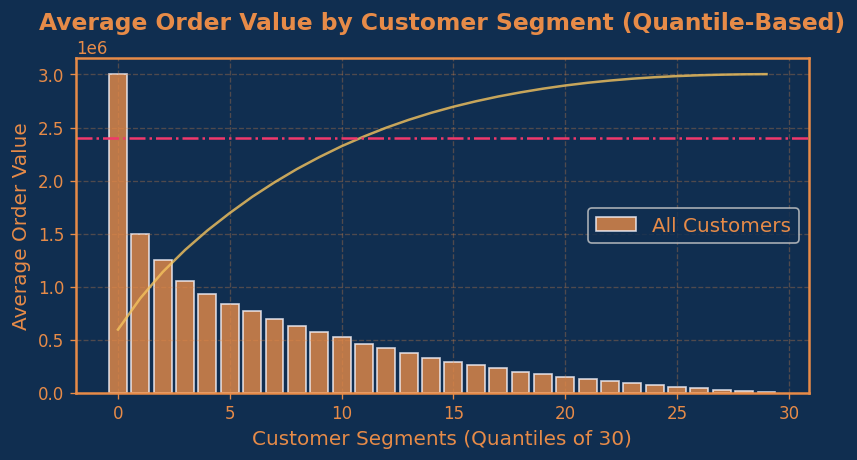

In [139]:
plot_cltv ([cltv], ["All Customers"])

For the next part of our question: “new,” “loyal,” “one‑time,” vs “churned” segments.<br>
We will first define new as "new users from last year".

In [140]:
last = pd.to_datetime(transactions["transaction_date"]).max()
last = datetime(last.year - 1, last.month, last.day)
last

datetime.datetime(2024, 2, 25, 0, 0)

In [141]:
transactions_filtered = transactions.copy()

customers_before = np.unique(transactions_filtered[pd.to_datetime(transactions_filtered["transaction_date"]) <  last]["customer_id"])
customers_after  = np.unique(transactions_filtered[pd.to_datetime(transactions_filtered["transaction_date"]) >= last]["customer_id"])

customers_new = np.setdiff1d(customers_after, customers_before)
customers_churned = np.setdiff1d(customers_before, customers_after)
customers_loyal = np.intersect1d(customers_before, customers_after)

customers_onetime = transactions_filtered.groupby(["customer_id"])["transaction_date"].count().reset_index()
customers_onetime = customers_onetime[customers_onetime["transaction_date"] == 1]
customers_onetime = customers_onetime["customer_id"].unique()

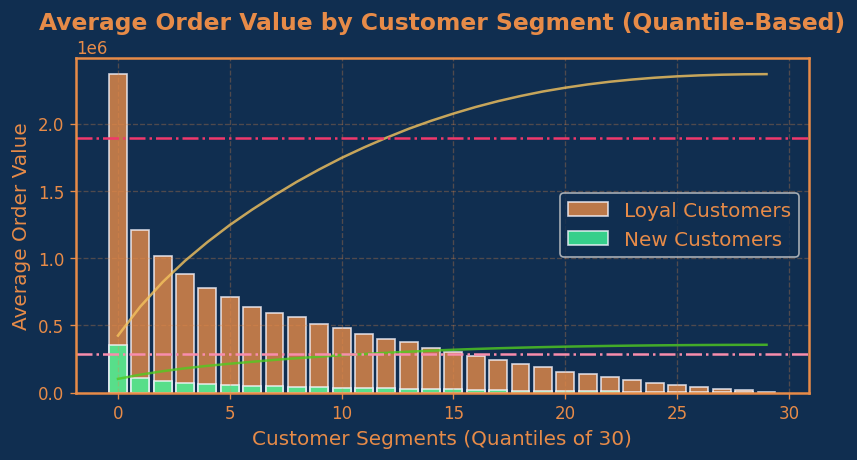

In [142]:
plot_cltv([cltv[cltv["customer_id"].isin(customers_loyal)], 
           cltv[cltv["customer_id"].isin(customers_new)]], 
          ["Loyal Customers", "New Customers"])

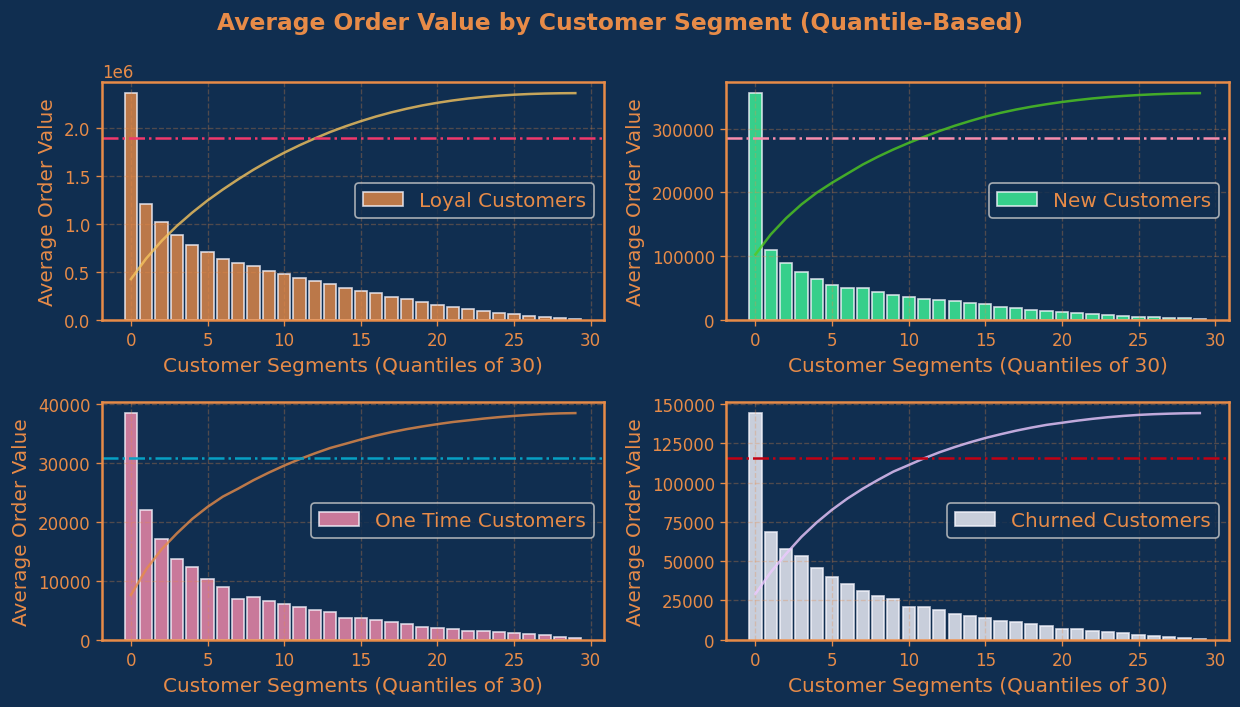

In [143]:
plot_cltv_subplots([cltv[cltv["customer_id"].isin(customers_loyal)], 
                    cltv[cltv["customer_id"].isin(customers_new)], 
                    cltv[cltv["customer_id"].isin(customers_onetime)], 
                    cltv[cltv["customer_id"].isin(customers_churned)]], 
                    ["Loyal Customers", "New Customers", "One Time Customers", "Churned Customers"])

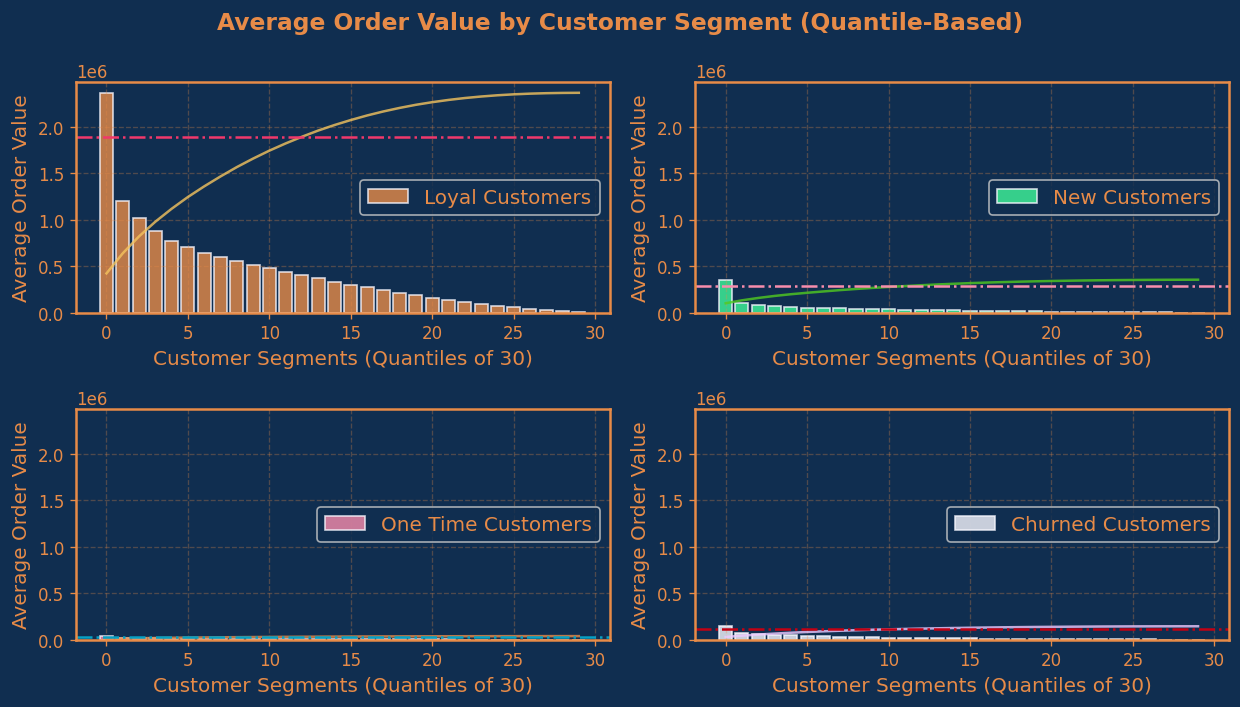

In [144]:
plot_cltv_subplots([cltv[cltv["customer_id"].isin(customers_loyal)], 
                    cltv[cltv["customer_id"].isin(customers_new)], 
                    cltv[cltv["customer_id"].isin(customers_onetime)], 
                    cltv[cltv["customer_id"].isin(customers_churned)]], 
                    ["Loyal Customers", "New Customers", "One Time Customers", "Churned Customers"], sharey=True)

## 3. Campaign Impact
Which channels deliver the highest ROI, and how much revenue is campaign‑attributed?

In [145]:
highest_roi = campaigns.groupby(["campaign_type"])["roi"].mean().reset_index().sort_values(by=["roi"], ascending=False)

In [146]:
highest_roi_kpi = highest_roi.iloc[0, 0]
highest_roi_kpi

'Search Engine Marketing'

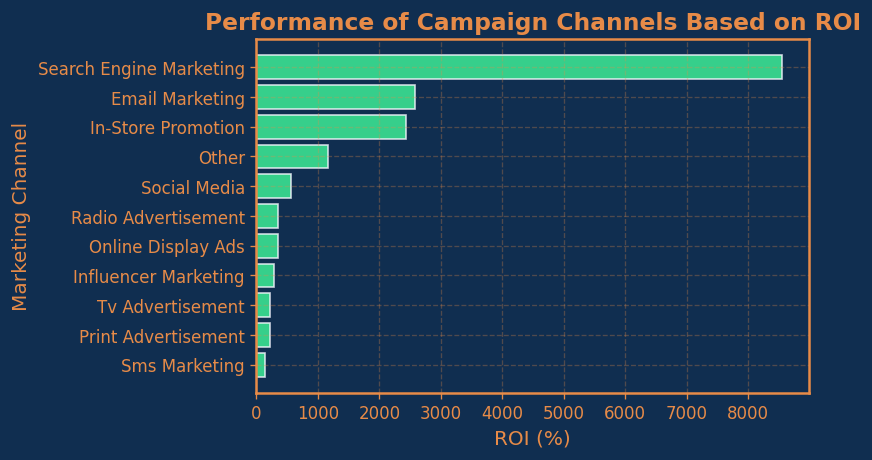

In [147]:
fig, ax = plt.subplots()

highest_roi_bar = highest_roi.sort_values(by=["roi"], ascending=True).copy()
ax.barh(highest_roi_bar["campaign_type"], highest_roi_bar["roi"], **bar_style[1])

ax.set_xlabel("ROI (%)")
ax.set_ylabel("Marketing Channel")
ax.set_title("Performance of Campaign Channels Based on ROI")
ax.grid(True)
plt.tight_layout()
plt.show()

There are two ways to estimate revenue for each campaign.<br>
1. We can just multiply ROI with budget.
2. We can get Average order value for the time duration of campaign and multiply it by conversions. We dont know which conversions lead to purchase and which lead to some other alternative like e.g signup, save to cart etc. As mentioned in the kaggle dataset description.<br>
Since we are going all in, why not use an optimizer? It basically just keeps on our calculation with different conversion rates until it hits a suitable conversion rate.

### 1. We can just multiply ROI with budget.

In [148]:
rev_est_calc = campaigns[["campaign_type", "budget", "roi"]].copy()
rev_est_calc["revenue"] = campaigns["budget"] * (1 + (campaigns["roi"] / 100))
rev_est_calc = rev_est_calc.drop(columns=["budget", "roi"]).groupby(
    ["campaign_type"]).sum().reset_index().sort_values(
    by=["revenue"], ascending=False).reset_index().drop(columns=["index"])

In [149]:
rev_est_calc["colors"] = pd.DataFrame([
    primary,
    secondary,
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color7,
    color8,
    background
])

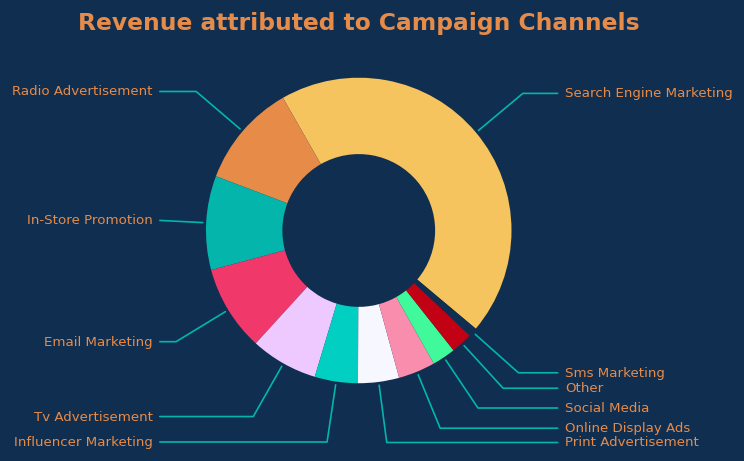

In [150]:
fig, ax = plt.subplots()

wedges, text = ax.pie(rev_est_calc["revenue"], colors=rev_est_calc["colors"], **pie_style)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    annot_style["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(rev_est_calc["campaign_type"].iloc[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **annot_style)

ax.set_title("Revenue attributed to Campaign Channels")
ax.grid(True)
plt.tight_layout()
plt.show()

### 2. Estimating using Average order value for the time duration of campaign and multiply it by conversions.
We start with 100% conversion_purchase_rate, then until the max value of estimated campaign conversion is atmost 70% that of the total revenue, we keep decreasing the conversion_purchase_rate.
<br>
<br>
So we have assumed, that the maximum the campaign revenue can be from the total reveneu, is 70%.

In [151]:
conversion_purchase_rate = 1
campaign_revenue_threshold = 0.7

In [152]:
def get_transactions_during (start_date, end_date):
    transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
    transactions_filtered = transactions[["transaction_date", "quantity", "price"]].copy()
    transactions_filtered["revenue"] = transactions_filtered["quantity"] * transactions_filtered["price"]
    transactions_filtered = transactions_filtered.drop(columns=["quantity", "price"])
    transactions_filtered = transactions_filtered[
        (start_date <= transactions_filtered["transaction_date"]) & 
        (transactions_filtered["transaction_date"] < end_date)]
    return transactions_filtered["revenue"]



def optimize_conversion_purchase_rate (conversion_purchase_rate, row, threshold=campaign_revenue_threshold):
    if row["diff"] >= (1 - threshold):
        return row

    conversion_purchase_rate = conversion_purchase_rate / 2
    row["campaign_revenue"] = row["conversions"] * conversion_purchase_rate * row["aov"]
    row["diff"] = (row["total_revenue"] - row["campaign_revenue"]) / row["total_revenue"]
    return optimize_conversion_purchase_rate (conversion_purchase_rate, row)

In [153]:
campaigns_filtered = campaigns[["campaign_id", "start_date", "end_date", "conversions"]].copy()
campaigns_filtered["start_date"] = pd.to_datetime(campaigns_filtered["start_date"])
campaigns_filtered["end_date"] = pd.to_datetime(campaigns_filtered["end_date"])

revenue_during_period = campaigns_filtered
revenue_during_period["aov"] = revenue_during_period.apply(
    lambda row: get_transactions_during(
        row["start_date"], 
        row["end_date"]).mean(), axis=1
    )
revenue_during_period["total_revenue"] = revenue_during_period.apply(
    lambda row: get_transactions_during(
        row["start_date"], 
        row["end_date"]).sum(), axis=1
    )

revenue_during_period["campaign_revenue"] = revenue_during_period["conversions"] * conversion_purchase_rate * revenue_during_period["aov"]
revenue_during_period["diff"] = (revenue_during_period["total_revenue"] - revenue_during_period["campaign_revenue"]) / revenue_during_period["total_revenue"]

revenue_during_period = revenue_during_period.apply(lambda row: optimize_conversion_purchase_rate(conversion_purchase_rate,  row), axis=1)
rev_est_conv = revenue_during_period.merge(campaigns, left_on="campaign_id", right_on="campaign_id")
rev_est_conv = rev_est_conv[["campaign_type", "campaign_revenue"]]

campaigns_filtered = None
revenue_during_period = None

In [154]:
rev_est_conv = rev_est_conv.groupby(
    ["campaign_type"]).sum().reset_index().sort_values(
    by=["campaign_revenue"], ascending=False).reset_index().drop(columns=["index"])

In [155]:
rev_est_conv["colors"] = pd.DataFrame([
    primary,
    secondary,
    color1,
    color2,
    color3,
    color4,
    color5,
    color6,
    color7,
    color8,
    background
])

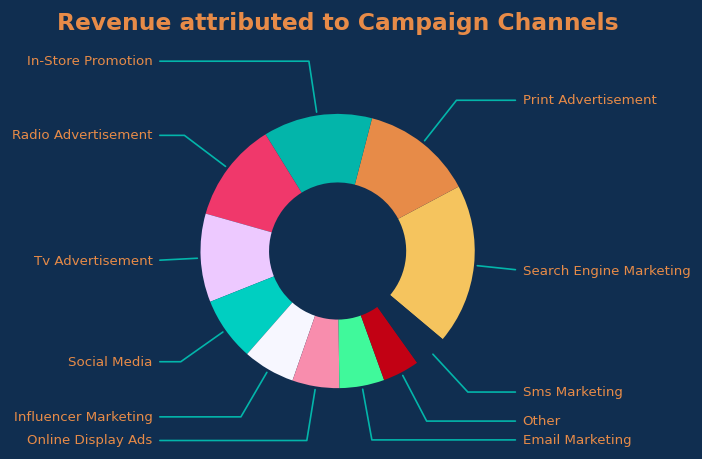

In [156]:
fig, ax = plt.subplots()

wedges, text = ax.pie(rev_est_conv["campaign_revenue"], colors=rev_est_conv["colors"], **pie_style)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    annot_style["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(rev_est_conv["campaign_type"].iloc[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **annot_style)

ax.set_title("Revenue attributed to Campaign Channels", pad=30)
ax.grid(True)
plt.tight_layout()
plt.show()

## 4. Funnel Performance
Where are the biggest drop‑off points (view → cart → purchase) and how does session duration affect conversion?

There are many ways we can compress/aggregate the funnel data.<br>
1. Unique set and keep only the important pages.
2. Unique set, but all pages.
3. Count visits for each page.
<br>
<br>

It does not stop here. We can.<br>
1. Do above for each user (aggregate sessions).
2. Do above for each session.

In [179]:
path_log = "../log/"
path_plot = "../plots/"
criteria = ["Other", "Product_View", "Add_to_cart", "Checkout", "Purchase", "Leave"]

In [180]:
interactions_filtered = interactions[interactions["channel"].isin(["Web", "Mobile App"])].copy()
interactions_filtered["interaction_date"] = pd.to_datetime(interactions_filtered["interaction_date"])
interactions_filtered = interactions_filtered.sort_values(by=["customer_id", "session_id", "interaction_date"])

In [181]:
def get_set (items):
    _, idx = np.unique(items, return_index=True)
    return np.array(items)[idx]



def filter_set (items, criteria=criteria):
    items = np.array(items)
    mask = np.isin(items, criteria)
    new_items = np.where(mask, items, "Other")

    xy, x_ind, y_ind = np.intersect1d(new_items, criteria, return_indices=True)
    return new_items[x_ind]



def get_last (my_list):
    if isinstance(my_list, list):
        last_el = my_list[-1]
        return get_last(last_el)
    else:
        return my_list
    


def get_interaction_combination (outer_list, new_el):
    last_el = get_last(outer_list)
    new_list = [last_el, new_el]

    if isinstance(outer_list, list):
        if isinstance(outer_list[-1], list):
            return [*outer_list, new_list]
        else:
            return [outer_list, new_list]
        
    return [new_list]



def get_interaction_combinations (df):
    df = df["interaction_type"].apply(lambda x: reduce(get_interaction_combination, x))
    all_interactions = [(sub_list[0], sub_list[1]) for row in df for sub_list in row]
    count_interactions = Counter(all_interactions).items()
    return count_interactions



def get_sankey (df, criteria=criteria):
    count_interactions = get_interaction_combinations(df)
    source = []
    target = []
    value = []
    for count in count_interactions:
        source.append(criteria.index(count[0][0]))
        target.append(criteria.index(count[0][1]))
        value.append(count[1])
    return source, target, value



def plot_sankey (df, name="Journey_Sankey", criteria=criteria):
    source, target, value = get_sankey(df)

    fig = go.Figure(data=[go.Sankey(
        node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = criteria,
        color = [primary, secondary, color2, color7, color6]
        ),
        link = dict(
        arrowlen = 70,
        source = source,
        target = target,
        value = value,
        # color = [primary, secondary, color2, color7, color6]
    ))])

    fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
    fig.write_html(path_plot+name+".html", auto_open=True)

### 1. Keep only the important pages
#### 1. For each user

In [182]:
journey = interactions_filtered.groupby(by=["customer_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: get_set(items)).apply(lambda items: filter_set(items))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave") if len(x) == 1 else x)

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "users"]

#### 2. For each session

In [171]:
journey = interactions_filtered.groupby(by=["session_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: get_set(items)).apply(lambda items: filter_set(items))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave") if len(x) == 1 else x)

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "sessions"]

In [183]:
plot_sankey(journey)

### 2. Keep all pages
#### 1. For each user

In [163]:
journey = interactions_filtered.groupby(by=["customer_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: get_set(items))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave") if len(x) == 1 else x)

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "users"]

#### 2. For each session

In [164]:
journey = interactions_filtered.groupby(by=["session_id"])["interaction_type"].agg(list).reset_index()
journey["interaction_type"] = journey["interaction_type"].apply(lambda items: get_set(items))
journey["interaction_type"] = journey["interaction_type"].apply(lambda x: np.append(x, "Leave") if len(x) == 1 else x)

pages_visited = journey["interaction_type"].apply(lambda items: len(items)).value_counts().reset_index().sort_values(by=["interaction_type"])
pages_visited.columns = ["pages", "sessions"]

### 3. Count visits for each page
#### 1. For each user

In [165]:
journey = interactions_filtered.groupby(by=["customer_id", "interaction_type"])["interaction_id"].count().reset_index()

#### 2. For each session

In [166]:
journey = interactions_filtered.groupby(by=["session_id", "interaction_type"])["interaction_id"].count().reset_index()

## 5. Product & Timing Insights
Which products are often a customer’s first purchase, which are trending or declining, and what day/hour windows maximize campaign conversion?

## 6. Pain Points & Issues
Which products see the highest cart abandonment, what share of sessions bounce, and what are the top support‑ticket categories?